# Credits

Originally created for a previous version of the [02456-deep-learning](https://github.com/DeepLearningDTU/02456-deep-learning) course material, but [converted to PyTorch](https://github.com/pytorch/tutorials).
See repos for credits.

In [1]:
## Install pandas if you don't already have it (uncomment line below)

# ! pip install pandas

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# Tying everything together

Now that you have learned about the three most used network architectures: FFNs, CNNs and RNNs. It is time to combine these network types into a more advanced model. 
It often happens that you have a combination of data that cannot fully be modeled by any one of these three types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](kaggle.com) that contains several different kinds of data.
First we will download the data and visualize it, and then we will train a network to classify the data.
A simple network with poor performance in provided for you as a starting point, but it is up to you use the things you have learnt to improve the results.


## Kaggle challenge
Kaggle is a website to participate in real life challenges.
Early 2017 it was bought by Google, who wanted access to the global community of data scientists it has created over the last 7 years.
Since then Google have sponsored its expansion and now the prizes of the competitions and the amount of public datasets are bigger than ever. 
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

The challenge we will pursue is the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge.
The dataset consists approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample. We will primarily look into the type of neural network best suited for handling this type of data. 

Lastly, we will train the model and put the outputs in a submission file that we can submit to Kaggle.

# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create a user
1. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
1. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch\4_Mini_Project
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [2]:
image_paths = glob.glob("images/*.jpg")
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
train_images = ['images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv('test.csv')

Total Observations:	 1584


## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint** You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [3]:
# Your code to produce answers here:
print(train.shape[0],'Training examples')
print(test.shape[0],'Test examples')
print(train.shape[1],'Columns in train set')
print(test.shape[1],'Columns in test set')
print('The species columns is missing from the test set')
samples = float(train.groupby(['species']).size().to_frame('No. samples').reset_index()['No. samples'].unique())
species  = train.groupby(['species']).size().to_frame('No. samples').reset_index()['species'].nunique()
print(species,'Unique species in the trainign set')
print(samples,' Samples per species')


990 Training examples
594 Test examples
194 Columns in train set
193 Columns in test set
The species columns is missing from the test set
99 Unique species in the trainign set
10.0  Samples per species


 * **Answer:**
 
 The train dataset has 990 rows and 194 colums while the test dataset has 594 rows and 193 columns. 99 unique species are missing from the training set and 10 samples per species

With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discern **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

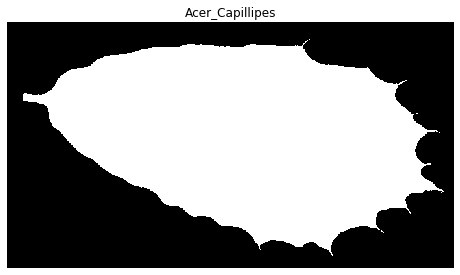

In [4]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its' index in our list of images in order to find the correct image
indexes = [image_paths.index('images/{}.jpg'.format(i)) for i in species_examples]

# Plot of the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[0], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

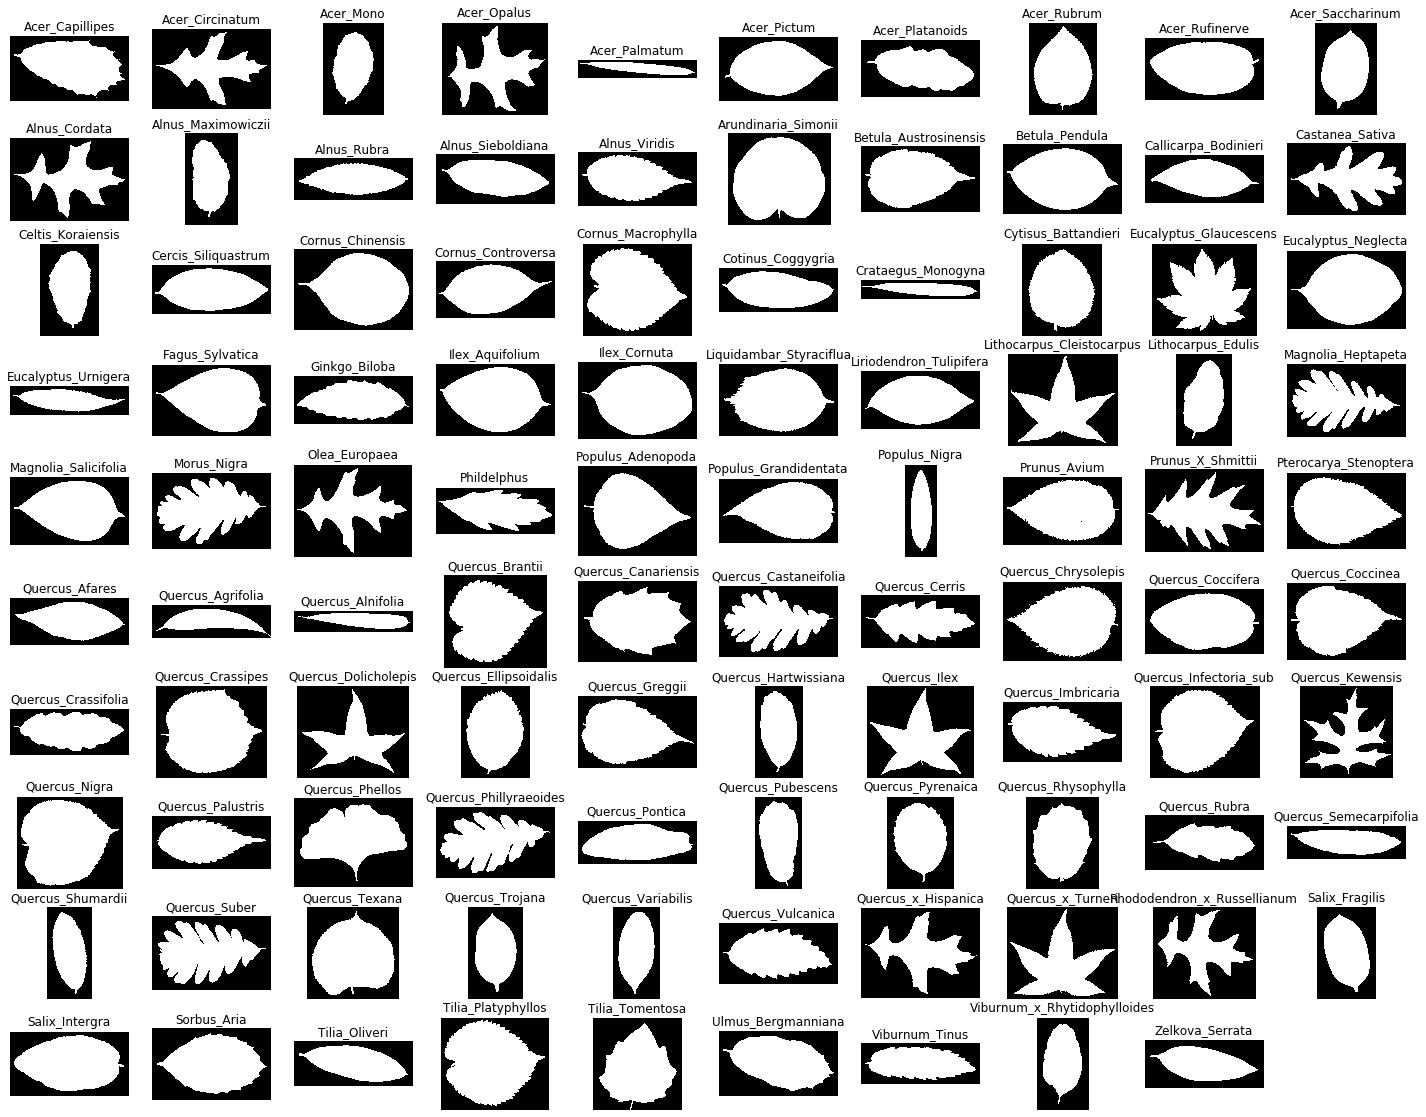

In [5]:
# Now plot 1 image from each category:
plt.figure(figsize=(25, 20))


for i in range(len(species)):
    image = imread(image_paths[i], as_gray=True)
    plt.subplot(10,10,i+1)
    plt.imshow(image, cmap='gray')
    plt.title("%s" % (species[i]))
    plt.axis('off')
    


As you can see, classifying leaves is actually a very tough problem.
What makes it even worse, is that we cannot use all the image data we have available.
In order to decrease the amount of computations needed, we need to reduce the size of the images as much as possible.
On top of that our neural network usually only accepts fixed size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its' shape into account seems extremely difficult.

Therefore we will 
- 1) first pad all the images into squares, and
- 2) then resize them, as visualized below:

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is to small should ultimately be determined by an actual test, but what makes visual sense is a good place to start.
Change the `image_size=(?, ?)` parameter below, and note your choice.

 * **Answer:**
 I believe a good small size is (40,40). It is significanlty smaller than the original ones. we can still make conclusion about which category they belong to.


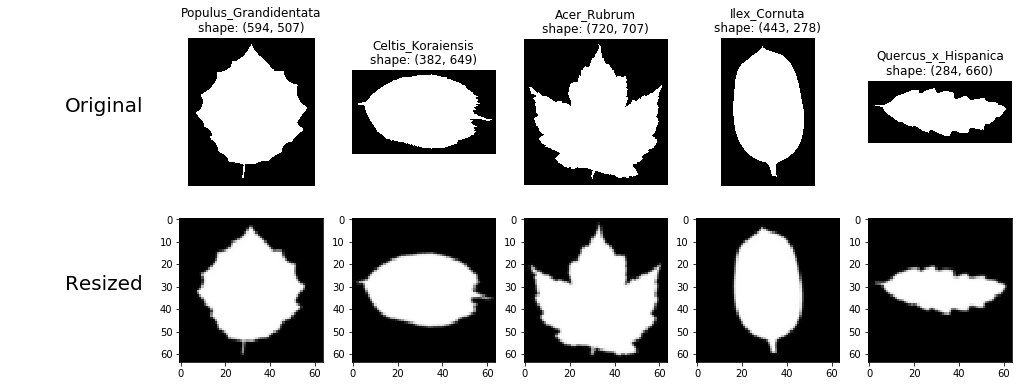

In [6]:
## Image pre-processing
image_size = (64, 64)  # <-- YOUR CODE HERE

# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = data_utils.pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Try to run it a few times to try and get an understanding of how the features differ from species to species.

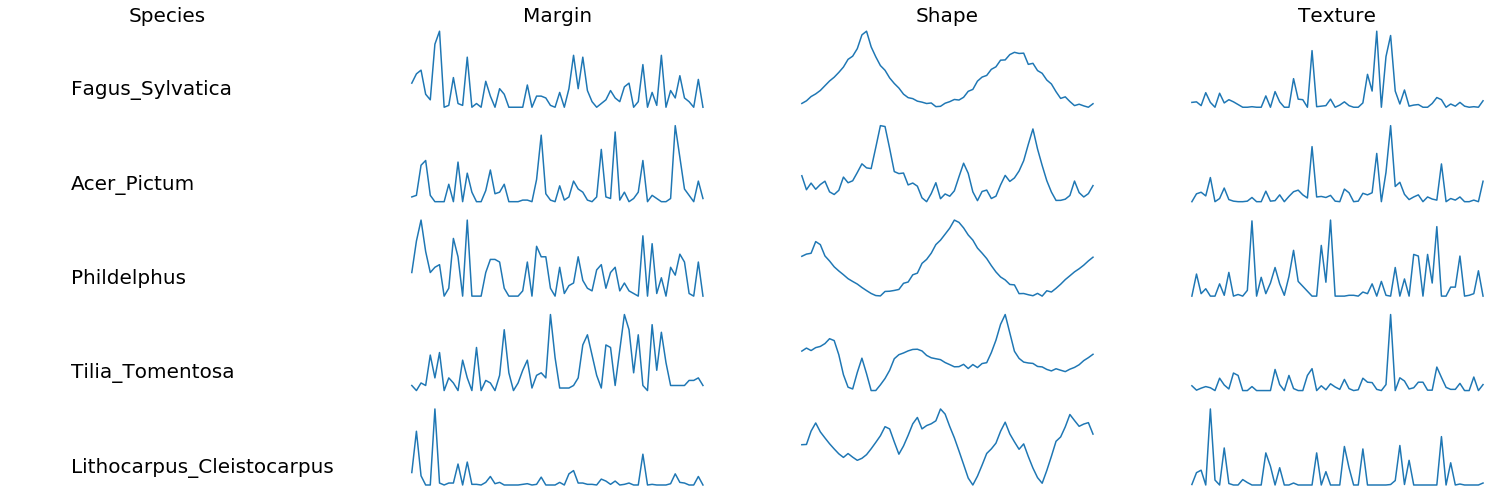

In [7]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Exercise 4
So far we have learned about the feed forward neural network (FFNN), the convolutional neural network (CNN) and the recurrent neural network (RNN).

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?


 * **Answer:**
 
 For **image** classification the most appropriate kind of network is the convolutional neural network. CNNs are very effective in reducing the number of parameters without losing on the quality of models. Images have high dimensionality therefore fits the abilites of CNN. From image **shape** can be extracted too.
 
 However, the **shape** seems that forms a general patern where all the species shows these two belly curves therefore feed forwards neural network would fit in this case.

 For **texture** and **margin** texture and margin seems that they change over a period of time thus RNN should be more apporiate

 
 

# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you going to work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [8]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (64,64,1)   # <-- Your answer here
NUM_CLASSES = 99   # <-- Your answer here 

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = 64  # <-- Your answer here

In [9]:
# Paths to data
TRAIN_PATH = "train.csv" 
TEST_PATH = "test.csv" 
IMAGE_PATHS = glob.glob("images/*.jpg")

# train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594

@@@Shape checking of data sets@@@
TRAIN
	images	(990, 64, 64, 1)0.280237
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 64, 64, 1)	0.280518
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time.

In [11]:
#import pickle

## Dump the data into a pickle file
#with open('data.pickle', 'wb') as f:
#    pickle.dump(data, f)
    
## Load the data from a pickle file
#with open('data.pickle', 'rb') as f:
#    data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

 * **Answer:**
 
 Smaller batch sizes are noisy, offering a regularizing effect and lower generalization error. Additionally,they occupy less memory.
 
 Larger batch sizes on the other hand they can speed up the training process because we can split up the training examples between different worker nodes. On the other hand larger batch sizes, tend to generalize worse to test data, compare to smaller batch sizes.
 
 Thus, the goal is to achieve the same test error as small batch sizes using large batch sizes. This would allow us to significantly speed up training without sacrificing model accuracy.

In [10]:
batch_size = 30
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (30, 64, 64, 1)
	margins, (30, 64)
	shapes, (30, 64)
	textures, (30, 64)
	ts, (30, 99)

VALID
	images, (30, 64, 64, 1)
	margins, (30, 64)
	shapes, (30, 64)
	textures, (30, 64)
	ts, (30, 99)

TEST
	images, (30, 64, 64, 1)
	margins, (30, 64)
	shapes, (30, 64)
	textures, (30, 64)
	ids, 30


# Build the model

In [11]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [12]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


## Exercise 7
7.1) Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [29]:
height, width, channels = IMAGE_SHAPE

conv_out_channels = 6 # <-- Filters in your convolutional layer
kernel_size =  2     # <-- Kernel size
conv_stride =  2      # <-- Stride
conv_pad    =  0     # <-- Padding
pool=2
filter2_out = 12
filter3_out=24
filter4_out = 36

 
# Keep track of features to output layer
features_cat_size = 296# <-- Number of features concatenated before output layer
    
def compute_conv_dim(dim_size, kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)
  
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
 #First Convolutional layer    
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        
         #evaluating image dimensions after first layer
        self.conv1_out_height = compute_conv_dim(height, kernel_size, conv_pad,   conv_stride)
        self.conv1_out_width = compute_conv_dim(width,   kernel_size,  conv_pad,  conv_stride)
        
         #first pooling
        self.pool = nn.MaxPool2d(pool, pool)
        #evaluating image dimensions after first pooling
        self.conv2_out_height = compute_conv_dim(self.conv1_out_height, pool, conv_pad,   pool)
        self.conv2_out_width = compute_conv_dim(self.conv1_out_width,  pool,  conv_pad,  pool)
        self.norm1 = nn.BatchNorm2d(conv_out_channels)
        
#    #Second Convolution layer
        self.conv_2 = nn.Conv2d(conv_out_channels, filter2_out, kernel_size)
        #evaluating image dimensions after second convolution
        self.conv3_out_height = compute_conv_dim(self.conv2_out_height, kernel_size, conv_pad,   conv_stride)
        self.conv3_out_width = compute_conv_dim(self.conv2_out_width,  kernel_size,  conv_pad,  conv_stride)
        
        #second pooling
        self.pool = nn.MaxPool2d(pool, pool)
        #evaluating image dimensions after second pooling
        self.conv4_out_height = compute_conv_dim(self.conv3_out_height, pool, conv_pad,   pool)
        self.conv4_out_width = compute_conv_dim(self.conv3_out_width,  pool,  conv_pad,  pool)
        self.norm2 = nn.BatchNorm2d(filter2_out)
        

    # Third convolutional layer
        self.conv_3 = nn.Conv2d(filter2_out, filter3_out,  kernel_size=kernel_size,
                             stride=conv_stride,  padding=conv_pad)
        self.norm3 = nn.BatchNorm2d(filter3_out)
        
   

        #fourth convilutional layer
        self.conv_4 = nn.Conv2d(filter3_out, filter4_out,  kernel_size=kernel_size,
                             stride=conv_stride,  padding=conv_pad)
   
        self.norm4 = nn.BatchNorm2d(filter4_out)
        
        self.dropout1=nn.Dropout2d(p=0.1)
        

        
        # Exercise: Add a recurrent unit like and RNN or GRU
        # >> YOUR CODE HERE <<
        self.rnn_1 = nn.GRU(input_size=192,
                         hidden_size=32,
                         num_layers=1)
        

        self.l_out = Linear(in_features=features_cat_size,
                            out_features=NUM_CLASSES,
                            bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        batch_size=x_img.shape[0]
        #print('the batch size is',batch_size)
        
        ## Convolutional layer ##
        # >> YOUR CODE HERE <<
        
        # - Change dimensions to fit the convolutional layer 
        x_img = x_img.permute(0,3,1,2) #btach size*width*height*channel
       
        
       ## Convolutional layer 1 ##
        "Sequence is conv->batchnorm->relu->dropout->pool"
        x_img = self.dropout1(self.pool(self.norm1(relu(self.conv_1(x_img)))))
        
        ## Convolutional layer2
        "Only conv->relu"
        
        x_img = self.dropout1(self.pool(self.norm2(relu(self.conv_2(x_img)))))
        
        ## Convolutional layer3
        x_img = self.dropout1(self.norm3(relu(self.conv_3(x_img))))
        
        ## Convolutional layer3
        x_img = self.dropout1(self.norm4(relu(self.conv_4(x_img))))
        
        # Append features to the list "features"
        x_img = x_img.view(-1,x_img.shape[1]*x_img.shape[2]*x_img.shape[3])
        #print('after xview x_img',x_img.shape)
        
        features.append(x_img)
        #print('feature_cat_1', x_img.shape[1])

        
    
        
        # Append features to the list "features"
        features.append(x_img)
        
        
        ## Use concatenated leaf features for FFNN ##
        x = torch.cat((x_margin,x_shape, x_texture), dim=1)  # if you want to use features as feature vectors
        features_vector = x
        #print('features vector', features_vector.shape)
        #print('feature_cat_2', x.shape[1])
        features.append(features_vector)
        
        
        ## Use concatenated leaf features for RNN ##
        # - Chage dimensions to fit GRU
       # print('bfore feature reshape', x.shape)
        x=x.view(x.shape[0],-1).unsqueeze(0) 
        #print('befoe gru, after concat',x.shape)
        # - Apply GRU
        x = self.rnn_1(x)[0]
        x = x.squeeze()
        #print('after rnn', x.shape)
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        x = x.view(x.shape[0],-1) #output RNN

        #print('the features_rnn', features_rnn.shape)
        
        
        # Append features to the list "features"
        features.append(x)
        
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)
        #print('feature final',features_final.shape)
        
        
        out['out'] = self.l_out(features_final)
        
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(1, 6, kernel_size=(2, 2), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(6, 12, kernel_size=(2, 2), stride=(1, 1))
  (norm2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(12, 24, kernel_size=(2, 2), stride=(2, 2))
  (norm3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(24, 36, kernel_size=(2, 2), stride=(2, 2))
  (norm4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (rnn_1): GRU(192, 32)
  (l_out): Linear(in_features=296, out_features=99, bias=False)
)


# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [39]:
LEARNING_RATE = 0.0001
criterion = nn.CrossEntropyLoss()         #<-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [40]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

tensor([[  1.8238,   4.8225,   0.7143,  ...,  -6.0771, -16.0519,   7.3250],
        [ -8.8719,  -6.0833,  -0.0978,  ...,   1.6168,  -7.7033,  -2.9105],
        [ -8.3514,   3.2622,   0.6197,  ...,  -3.9349, -12.6623,  -2.1689],
        ...,
        [-10.8532, -10.5888, -16.8420,  ...,  -1.9000, -13.3205,  -9.8230],
        [  8.0130,  -5.6332,  -7.4969,  ...,  12.9385,  -1.9611, -13.1632],
        [  7.7767,   2.4118,  -9.8531,  ...,   1.0641,   1.0929,  -5.2057]],
       grad_fn=<MmBackward>)

# Train

Valid, it: 1000 loss: 0.25 accs: 0.93



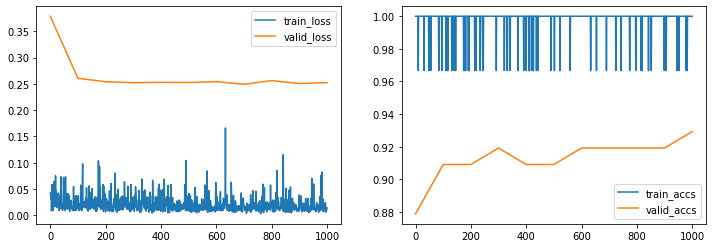

In [41]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 1000
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
        print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        clear_output(wait=True)
        #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

## Exercise 9

**Tip** This is very small dataset (number of observations) compared to the number of features.
This means that overfitting will likely be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start out simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred, you can change learning rate, try testing various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you of to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batchnormalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you cant. 


**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 


* Description of final architecture *

**Answer**

The final model architecture consists of 4 convolutional layers with two pooling  layers. Batchnormalization and dropout implemented in all convolutional layers. Then there was an rnnnetwork with the following features input_size=192, hidden_size=32, num_layers=1. Eventualluy there was only one fully connected layer.


* Description of training parameters *

**Answer**

The final learning rate was set at 0.0001 instead of 0.001 which was its initial value. The image size was to 64 * 64 * 1.
The batch size was set to 30.


* Description of final results (Kaggle and validation)

**Answer:**

With model accuracy of 93 percent the kaggle score is equal to 0.2. However, it seems that the model accuracy and the kaggle score aren't proportionaly related. Therefore the model it has to show good fit as well along with high accuracy in order to hit higher score in kaggle.


# Submission to Kaggle

First we have to make testset predictions, then we have to place it in the submission file and the upload to Kaggle for our score! You can upload at max 5 submissions a day.

In [42]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = softmax(output['out'].data,dim=1)

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

## Make submission file

In [43]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv('submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,1.799613e-09,2.498560e-07,1.162508e-10,9.515100e-06,2.271426e-08,7.367192e-10,2.047642e-10,1.961264e-12,2.239772e-07,...,2.972160e-11,2.001813e-08,7.544204e-06,2.444113e-08,1.750799e-07,8.136064e-10,1.110424e-11,5.607157e-06,1.715345e-11,2.802004e-11
1,7,1.856306e-05,3.721843e-08,8.581795e-07,3.752561e-04,1.483752e-07,9.247657e-07,3.777879e-07,5.383935e-07,4.550419e-08,...,1.812602e-08,1.758143e-03,1.100387e-07,1.060744e-05,1.345334e-06,4.355168e-05,7.358271e-05,1.201759e-06,4.957305e-06,2.942729e-02
2,9,2.091886e-08,9.884349e-01,4.162255e-06,7.266258e-04,9.719131e-07,6.289518e-08,4.820482e-05,2.051550e-06,6.088798e-03,...,4.206311e-09,8.430316e-08,4.409045e-08,1.299786e-06,2.394213e-08,5.326457e-07,3.390884e-08,5.339695e-09,6.022815e-09,8.811377e-06
3,12,3.494477e-09,2.050377e-07,1.457914e-11,1.689437e-11,3.248762e-08,4.097951e-10,2.896305e-09,4.635910e-08,1.251144e-06,...,1.927579e-05,6.554439e-11,6.820110e-07,2.522739e-10,1.338388e-08,4.067041e-08,2.157954e-05,1.364062e-11,1.101102e-08,3.552884e-07
4,13,9.908199e-10,1.963701e-07,1.606300e-13,5.203250e-10,2.672558e-08,6.443337e-12,2.404205e-10,5.272412e-10,1.624349e-05,...,6.027075e-06,4.045749e-12,5.675951e-03,2.659804e-08,3.306630e-06,1.841506e-09,1.762873e-07,1.947152e-09,1.944970e-09,7.225623e-10


## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 